# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

[(Timestamp('2008-01-05 00:00:00'), -155), (Timestamp('2008-01-11 00:00:00'), -200), (Timestamp('2008-02-03 00:00:00'), -238), (Timestamp('2008-02-14 00:00:00'), -239), (Timestamp('2008-02-15 00:00:00'), -260), (Timestamp('2008-02-16 00:00:00'), -294), (Timestamp('2008-02-17 00:00:00'), -272), (Timestamp('2008-02-19 00:00:00'), -260), (Timestamp('2008-02-20 00:00:00'), -343), (Timestamp('2008-02-21 00:00:00'), -322), (Timestamp('2008-02-23 00:00:00'), -267), (Timestamp('2008-02-24 00:00:00'), -272), (Timestamp('2008-02-25 00:00:00'), -217), (Timestamp('2008-02-26 00:00:00'), -216), (Timestamp('2008-02-27 00:00:00'), -288), (Timestamp('2008-02-28 00:00:00'), -272), (Timestamp('2008-03-05 00:00:00'), -221), (Timestamp('2008-03-06 00:00:00'), -255), (Timestamp('2008-03-07 00:00:00'), -222), (Timestamp('2008-03-28 00:00:00'), -122), (Timestamp('2008-03-29 00:00:00'), -111), (Timestamp('2008-03-30 00:00:00'), -122), (Timestamp('2008-04-24 00:00:00'), -71), (Timestamp('2008-04-25 00:00:00'),

<IPython.core.display.Javascript object>


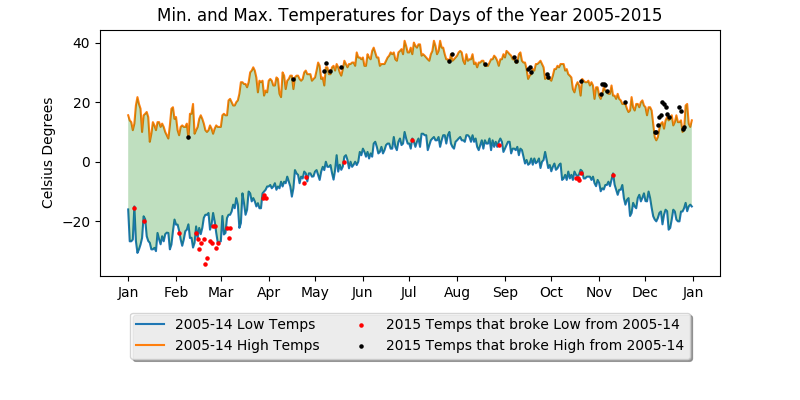

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import re
import numpy as np

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))
    
    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

#     plt.figure(figsize=(8,8))

#     plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

#     return mplleaflet.display()

    # Get CSV related to specific binsize and hash
    dly_info = pd.read_csv('data/C2A2_data/BinnedCsvs_d{}/{}.csv'.format(binsize, hashid)).sort_values(['Date', 'ID'])
    
    # Cut out February 29th
    dly_info = dly_info[~(dly_info['Date'].str.contains('02-29'))]
    
    # Make a column for just month and day
    dly_info['MandD'] = dly_info['Date'].apply(lambda x: re.split('\d\d\d\d[-]',x)[1])
    dly_info['Date_Same_Year'] = dly_info['Date'].apply(lambda x: '2008-' + re.split('\d\d\d\d[-]', x)[1])
    
    # Split into before 2015 and after 2015
    dly_info_after = dly_info[dly_info.Date >= '2015']
    dly_info_before = dly_info[dly_info.Date < '2015']
#     print(np.unique(dly_info_before['MandD']), return_inverse=True)

    # Group by the month and date field from above
    dly_info_before_grp = dly_info_before.groupby('MandD')
    dly_info_after_grp = dly_info_after.groupby('MandD')

    # Get the minimum and maximum of each grouped month and day
    minimum_before15 = dly_info_before.loc[dly_info_before_grp['Data_Value'].idxmin()]['Data_Value'].tolist()
    maximum_before15 = dly_info_before.loc[dly_info_before_grp['Data_Value'].idxmax()]['Data_Value'].tolist()
    minimum_after15 = dly_info_after.loc[dly_info_after_grp['Data_Value'].idxmin()]['Data_Value'].tolist()
    maximum_after15 = dly_info_after.loc[dly_info_after_grp['Data_Value'].idxmax()]['Data_Value'].tolist()
    
    #dates = dly_info_before['MandD'].unique().tolist()
    dates = dly_info_before['Date_Same_Year'].unique().tolist()
    dates = list(map(pd.to_datetime, dates))
    
    #convert these to series
    minimum_before15_series = pd.DataFrame(minimum_before15)
    maximum_before15_series = pd.DataFrame(maximum_before15)
    minimum_after15_series = pd.DataFrame(minimum_after15)
    maximum_after15_series = pd.DataFrame(maximum_after15)
    
    # go to each item before 15 and if the item at the same index in after 15 is greater
    # put it into a list with the index and value referenced
    less_than_before15 = []
    greater_than_before15 = []
    for i in range (len(minimum_after15)):
        if minimum_after15[i] < minimum_before15[i]:
            less_than_before15.append((dates[i], minimum_after15[i]))
            
    for i in range (len(maximum_after15)):
        if maximum_after15[i] > maximum_before15[i]:
            greater_than_before15.append((dates[i], maximum_after15[i]))
        
    print(less_than_before15)
    print(greater_than_before15)
    
    # Done incorrectly because we want to compare the minimum and maximum for each day
    # to the minimums and maximums for each day in 2015
#     minimum_before15 = min(minimum)
#     maximum_before15 = max(maximum)
#     print(minimum_before15, maximum_before15)
#     dly_info_after = dly_info[(dly_info.Data_Value < minimum_before15) | (dly_info.Data_Value > maximum_before15)]
    
    figure = plt.figure(figsize=[8, 4])
    
    
    import matplotlib.dates as mdates
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format - %b gives us Jan, Feb...
    fmt = mdates.DateFormatter('%b')

    minimum_before15 = pd.Series(minimum_before15).apply(lambda x: x/10).tolist()
    maximum_before15 = pd.Series(maximum_before15).apply(lambda x: x/10).tolist()

    plt.gca().fill_between(dates, minimum_before15, maximum_before15, facecolor='green', alpha=0.25)
    plt.gca().set_title('Min. and Max. Temperatures for Days of the Year 2005-2015')
    plt.gca().set_ylabel('Celsius Degrees')
#     plt.gca().legend(['Temperatures in 2015 that broke min or max record for 2005-2014'])
    plt.gca().xaxis.set_major_locator(locator)
    # Specify formatter
    plt.gca().xaxis.set_major_formatter(fmt)
#     myFmt = mdates.DateFormatter('%m')
#     plt.gca().xaxis.set_major_formatter(myFmt)
#     plt.xticks(range(len(dates)), dates)
    plt.plot(dates, minimum_before15, '-o', markersize=0, zorder=0, label='2005-14 Low Temps')
    plt.plot(dates, maximum_before15, '-o', markersize=0, zorder=0, label='2005-14 High Temps')
    #     date_indexes = dly_info_after['MandD'].apply(lambda x : dates.index(x)).tolist()
    plt.scatter([i[0] for i in less_than_before15], [i[1]/10 for i in less_than_before15], color='red', s=5, zorder=1, label='2015 Temps that broke Low from 2005-14')
    plt.scatter([i[0] for i in greater_than_before15], [i[1]/10 for i in greater_than_before15], color='black', s=5, zorder=2, label='2015 Temps that broke High from 2005-14')
#     plt.scatter(list(map(pd.to_datetime, dly_info_after['MandD'])), dly_info_after['Data_Value'].tolist(), color = 'red', s=5)
    chartBox = plt.gca().get_position()
    plt.gca().set_position([chartBox.x0, chartBox.y0 + .2, chartBox.width, chartBox.height*.8])
#     plt.gca().legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
    plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), shadow=True, ncol=2)
    figure.savefig('test.png', bbox_inches='tight')
leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')